In [1]:
!pip install transformers

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from tensorflow.keras.preprocessing.image import load_img
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from transformers import ViTModel, ViTFeatureExtractor
from tqdm import tqdm

In [3]:
def count_files_in_subdirs(directory, set_name):
    # Initialize an empty dictionary to hold the count of files for each subdirectory.
    counts = {}

    # Iterate over each item in the given directory.
    for item in os.listdir(directory):
        # Construct the full path to the item.
        item_path = os.path.join(directory, item)

        # Check if the item is a directory.
        if os.path.isdir(item_path):
            # Count the number of files in the subdirectory and add it to the dictionary.
            counts[item] = len(os.listdir(item_path))

    # Convert the counts dictionary to a DataFrame for easy viewing and analysis.
    # The index of the DataFrame is set to the provided set name.
    df = pd.DataFrame(counts, index=[set_name])
    return df

In [4]:
def split_data(data_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.1, 0.2)):

  for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    if os.path.isdir(class_dir):
      images = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
      random.shuffle(images)

      train_split = int(len(images) * split_ratio[0])
      val_split = int(len(images) * (split_ratio[0] + split_ratio[1]))

      train_images = images[:train_split]
      val_images = images[train_split:val_split]
      test_images = images[val_split:]

      # Create class directories in train, validation, and test directories
      os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
      os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)
      os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

      # Copy images to respective directories
      for image in train_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(train_dir, class_name, image)
        shutil.copy(src, dst)

      for image in val_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(val_dir, class_name, image)
        shutil.copy(src, dst)

      for image in test_images:
        src = os.path.join(class_dir, image)
        dst = os.path.join(test_dir, class_name, image)
        shutil.copy(src, dst)

# Example usage:
data_dir = '/kaggle/input/rafdb-data/DATASET/data'  # Replace with your data directory
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

split_data(data_dir, train_dir, val_dir, test_dir)

In [5]:
# Count the files in the subdirectories of the training directory and print the result.
train_count = count_files_in_subdirs(train_dir, 'train')
print(train_count)

# Count the files in the subdirectories of the testing directory and print the result.
test_count = count_files_in_subdirs(test_dir, 'test')
print(test_count)

# Count the files in the subdirectories of the testing directory and print the result.
val_count = count_files_in_subdirs(val_dir, 'val')
print(val_count)

       Angry  Neutral  Disgust  Happy  Fear   Sad  Surprise
train    606     2242      613   4169   248  1722      1133
      Angry  Neutral  Disgust  Happy  Fear  Sad  Surprise
test    174      641      176   1192    71  493       324
     Angry  Neutral  Disgust  Happy  Fear  Sad  Surprise
val     87      321       88    596    36  245       162


<Axes: >

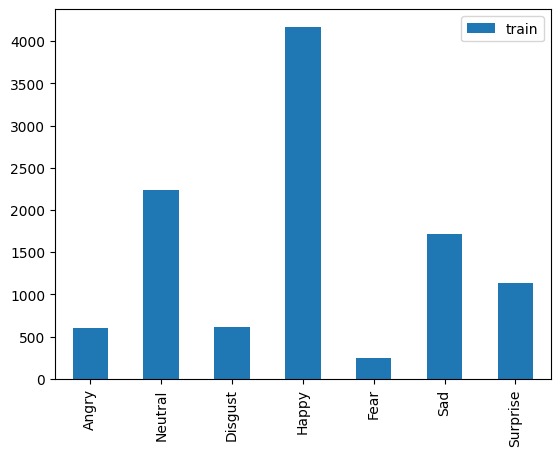

In [6]:
train_count.transpose().plot(kind='bar')

<Axes: >

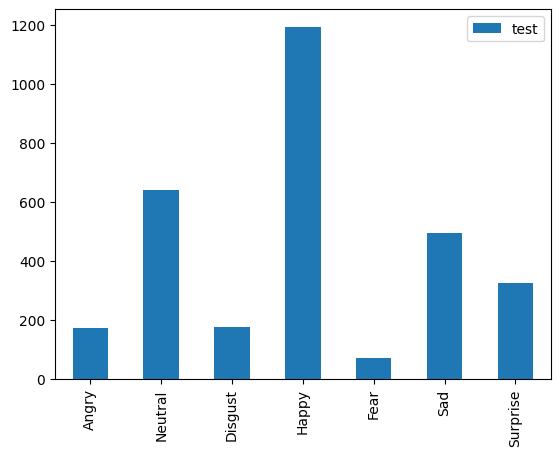

In [7]:
test_count.transpose().plot(kind='bar')

<Axes: >

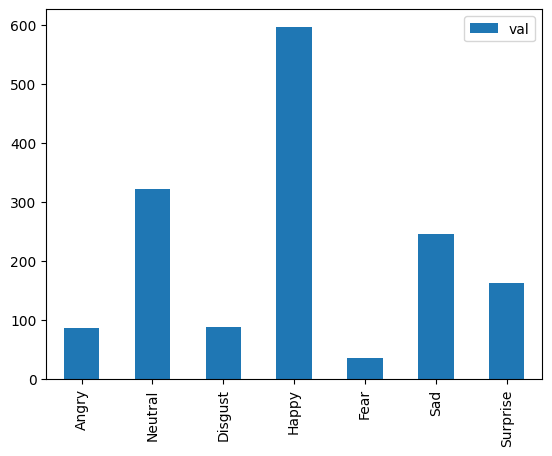

In [8]:
val_count.transpose().plot(kind='bar')

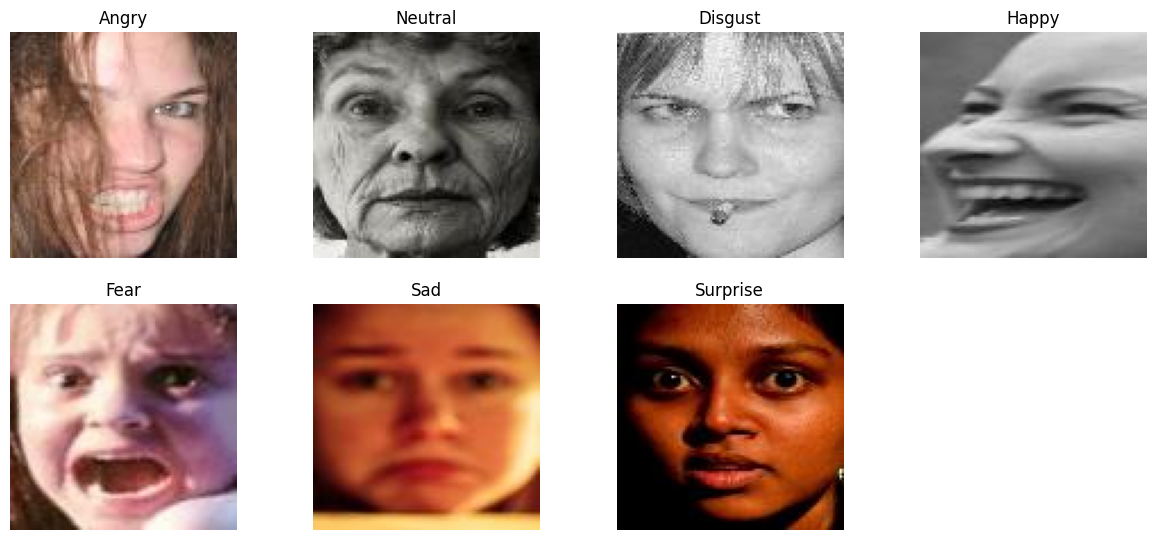

In [9]:
emotions = os.listdir(train_dir)
plt.figure(figsize=(15,10))

for i, emotion in enumerate(emotions, 1):
    folder = os.path.join(train_dir, emotion)
    img_path = os.path.join(folder, os.listdir(folder)[12])
    img = plt.imread(img_path)
    plt.subplot(3, 4, i)
    plt.grid()
    plt.imshow(img, cmap='gray')
    plt.title(emotion)
    plt.axis('off')

In [10]:
def plot_images_from_directory(directory_path, class_name, num_images=9):
    # Retrieve list of all file names in the directory
    image_filenames = os.listdir(directory_path)

    # If there are fewer images than requested, we'll just show them all
    if len(image_filenames) < num_images:
        print(f"Only found {len(image_filenames)} images in {directory_path}, displaying them all.")
        num_images = len(image_filenames)

    # Randomly select 'num_images' number of file names
    selected_images = random.sample(image_filenames, num_images)

    # Plotting the images
    fig, axes = plt.subplots(3, 3, figsize=(5, 5))  # Adjust the size as needed
    axes = axes.ravel()

    for i, image_file in enumerate(selected_images):
        image_path = os.path.join(directory_path, image_file)
        # image = Image.open(image_path)
        image = load_img(image_path)
        axes[i].imshow(image)
        axes[i].set_title(f"Image: {class_name}")
        axes[i].axis('off')  # Hide the axis

    plt.tight_layout()
    plt.show()

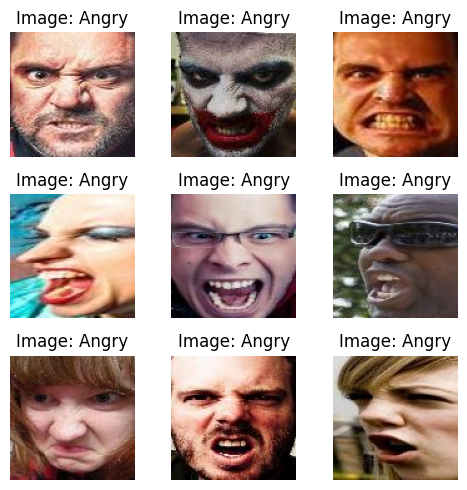

In [11]:
angry_directory_path = '/kaggle/working/train/Angry'
plot_images_from_directory(angry_directory_path, class_name = 'Angry')

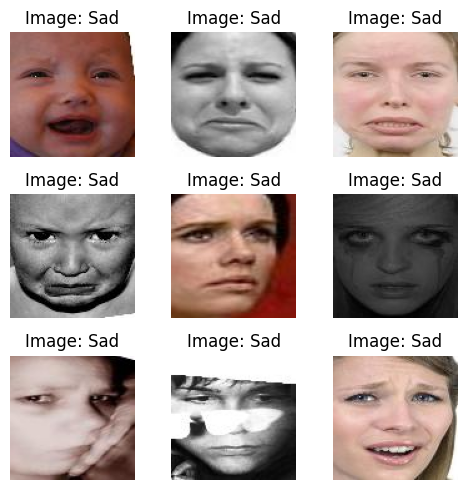

In [12]:
disgust_directory_path = '/kaggle/working/train/Sad'
plot_images_from_directory(disgust_directory_path, class_name = 'Sad')

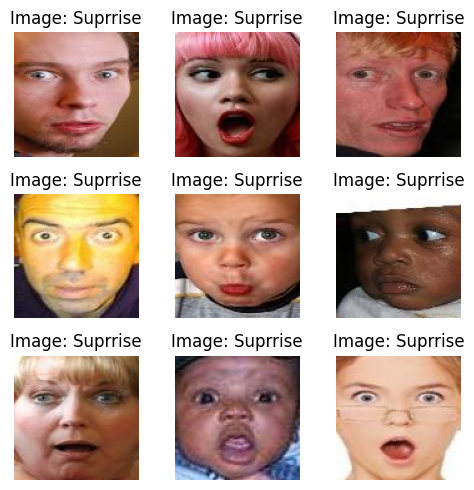

In [13]:
surpirse_directory_path = '/kaggle/working/train/Surprise'
plot_images_from_directory(surpirse_directory_path, class_name = 'Suprrise')

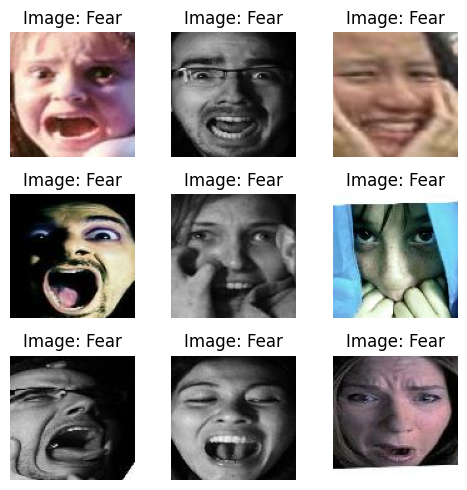

In [14]:
surpirse_directory_path = '/kaggle/working/train/Fear'
plot_images_from_directory(surpirse_directory_path, class_name = 'Fear')

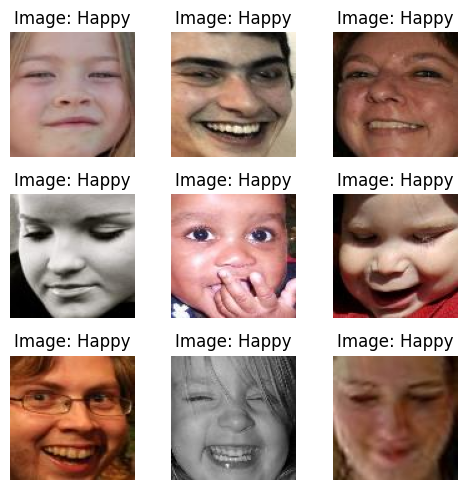

In [15]:
surpirse_directory_path = '/kaggle/working/train/Happy'
plot_images_from_directory(surpirse_directory_path, class_name = 'Happy')

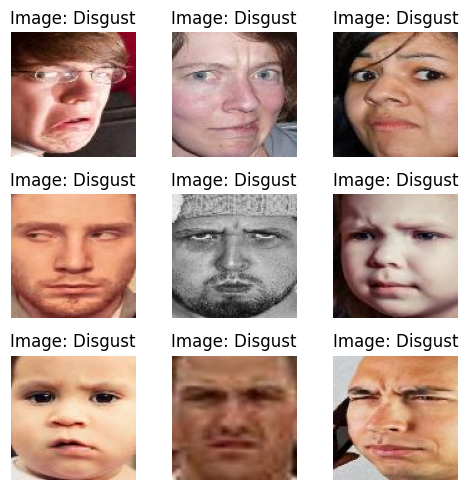

In [16]:
surpirse_directory_path = '/kaggle/working/train/Disgust'
plot_images_from_directory(surpirse_directory_path, class_name = 'Disgust')

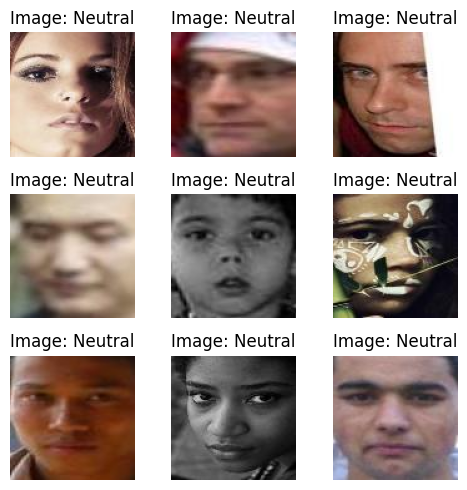

In [17]:
surpirse_directory_path = '/kaggle/working/train/Neutral'
plot_images_from_directory(surpirse_directory_path, class_name = 'Neutral')

In [18]:
import os
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

class EmotionDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.class_names = os.listdir(data_dir)

        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(data_dir, class_name)
            for img_file in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_file))
                self.labels.append(label)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (224, 224))

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert to PIL Image for torchvision transforms
    transforms.RandomHorizontalFlip(),  # Randomly flip images
    transforms.RandomRotation(10),  # Randomly rotate images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust color
    transforms.Resize((224, 224)),  # Resize to the target size
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

data_dir = '/kaggle/input/rafdb-data/DATASET/data'  
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'


In [19]:
# Create datasets
train_dataset = EmotionDataset(train_dir, transform)
val_dataset = EmotionDataset(val_dir, transform)  # You might want to use different transforms for validation
test_dataset = EmotionDataset(test_dir, transform)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [20]:
class ViTEmotionModel(nn.Module):
    def __init__(self, num_classes=7):
        super(ViTEmotionModel, self).__init__()
        self.feature_extractor = ViTModel.from_pretrained('google/vit-base-patch16-224')
        self.fc = nn.Linear(self.feature_extractor.config.hidden_size, num_classes)

    def forward(self, x):
        x = self.feature_extractor(x).last_hidden_state[:, 0, :]  # Use the [CLS] token
        x = self.fc(x)
        return x

model = ViTEmotionModel()

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
def calculate_accuracy(loader, model, device):
    model.eval()  
    correct = 0
    total = 0
    val_loss = 0.0
    criterion = nn.CrossEntropyLoss()  

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)  # Get the predicted classes
            total += labels.size(0)  # Total number of samples
            correct += (predicted == labels).sum().item()  # Count correct predictions

    accuracy = correct / total  # Calculate accuracy
    avg_loss = val_loss / len(loader)  # Average validation loss
    return accuracy, avg_loss

# Initialize lists to store accuracies and losses
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Training loop with metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Loop through training data
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to device
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader)
    train_accuracy = correct_train / total_train  # Training accuracy
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation step
    val_accuracy, val_loss = calculate_accuracy(val_loader, model, device)
    val_accuracies.append(val_accuracy)
    val_losses.append(val_loss)
    
    # Print metrics for each epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.4f}, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {val_accuracy:.4f}')

Epoch [1/10], Train Loss: 0.8548, Train Accuracy: 0.6963, Validation Loss: 0.6258, Validation Accuracy: 0.7792
Epoch [2/10], Train Loss: 0.5193, Train Accuracy: 0.8183, Validation Loss: 0.5526, Validation Accuracy: 0.7954
Epoch [3/10], Train Loss: 0.3721, Train Accuracy: 0.8674, Validation Loss: 0.5396, Validation Accuracy: 0.8182
Epoch [4/10], Train Loss: 0.2793, Train Accuracy: 0.8995, Validation Loss: 0.5630, Validation Accuracy: 0.8046
Epoch [5/10], Train Loss: 0.1910, Train Accuracy: 0.9321, Validation Loss: 0.5819, Validation Accuracy: 0.8248
Epoch [6/10], Train Loss: 0.1418, Train Accuracy: 0.9516, Validation Loss: 0.6168, Validation Accuracy: 0.8176
Epoch [7/10], Train Loss: 0.1366, Train Accuracy: 0.9504, Validation Loss: 0.6990, Validation Accuracy: 0.8156
Epoch [8/10], Train Loss: 0.0948, Train Accuracy: 0.9690, Validation Loss: 0.6421, Validation Accuracy: 0.8319
Epoch [9/10], Train Loss: 0.0676, Train Accuracy: 0.9777, Validation Loss: 0.7185, Validation Accuracy: 0.8098
E

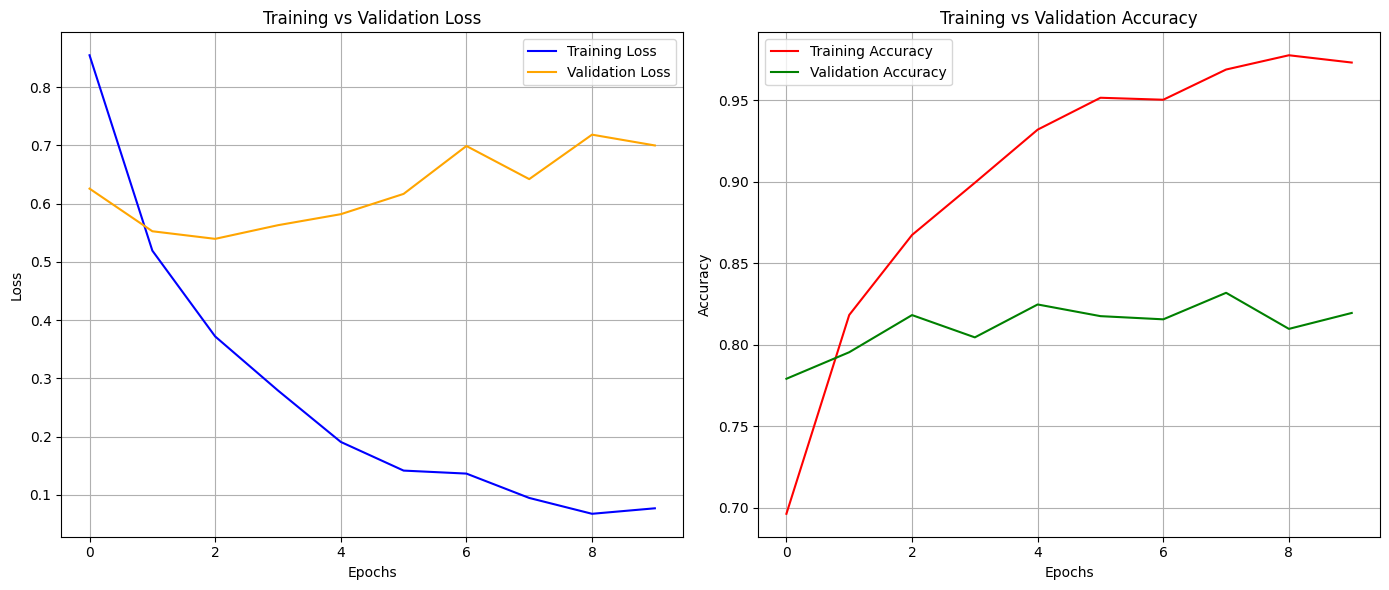

In [22]:
plt.figure(figsize=(14, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy', color='red')
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [25]:
model.eval()

correct = 0
total = 0

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass to get predictions
        outputs = model(images)

        # Get the predicted class with the highest score
        _, predicted = torch.max(outputs, 1)

        # Update correct predictions count and total samples count
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

# Calculate accuracy

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 83.26%


Classification Report:
               precision    recall  f1-score   support

       Angry       0.69      0.71      0.70       174
     Disgust       0.75      0.86      0.80       641
        Fear       0.65      0.49      0.56       176
       Happy       0.95      0.91      0.93      1192
     Neutral       0.71      0.55      0.62        71
         Sad       0.81      0.79      0.80       493
    Surprise       0.79      0.84      0.81       324

    accuracy                           0.83      3071
   macro avg       0.76      0.74      0.75      3071
weighted avg       0.83      0.83      0.83      3071



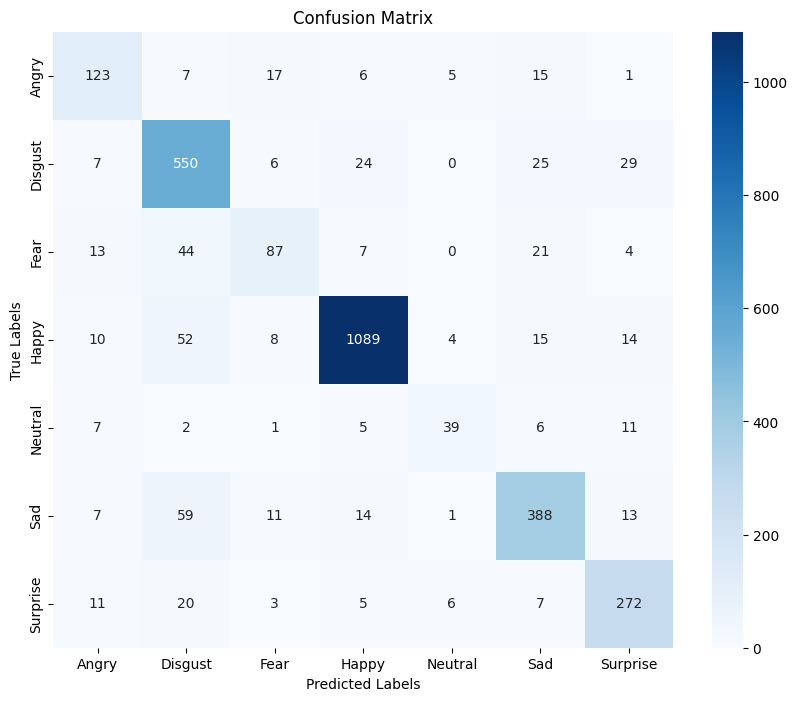

In [30]:
# Calculate predictions and true labels for the entire test set
all_labels = []
all_predictions = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Generate the classification report
report = classification_report(all_labels, all_predictions, target_names=Emotion_Classes)
print("Classification Report:\n", report)

# Generate the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=Emotion_Classes, yticklabels=Emotion_Classes)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


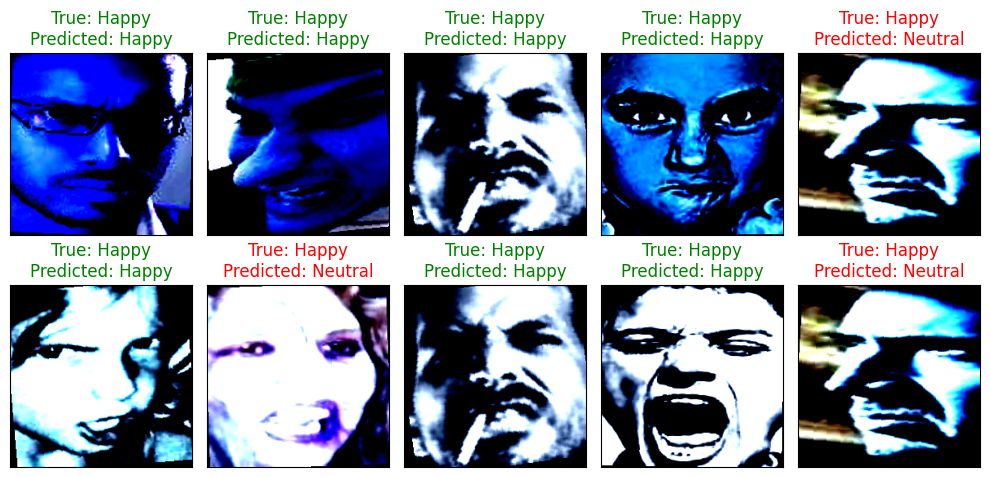

In [31]:
# Emotion classes for the dataset
Emotion_Classes = ['Happy', 'Sad', 'Neutral', 'Angry', 'Fear', 'Suprise', 'Disgust']

# Selecting a random batch from the test loader
Random_batch = np.random.randint(0, len(test_loader) - 1)
images, labels = next(iter(test_loader))
Random_Img_Index = np.random.randint(0, images.size(0), 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i, ax in enumerate(axes.flat):
        Random_Img = images[Random_Img_Index[i]].to(device)
        Random_Img_Label = labels[Random_Img_Index[i]]

        # Making a prediction using the model
        Model_Prediction = torch.argmax(model(Random_Img.unsqueeze(0)), dim=1).item()

        # Displaying the image
        ax.imshow(np.transpose(Random_Img.cpu().numpy(), (1, 2, 0)))  # Assuming the images are in CxHxW format
        # Setting the title with true and predicted labels, colored based on correctness
        color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
        ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()